In [7]:
import stompy.model.delft.dflow_model as dfm
import pesca_base
import xarray as xr
import matplotlib.pyplot as plt
from stompy.plot import plot_wkb
import six
from stompy import utils, filters
import numpy as np
%matplotlib notebook

In [58]:
def local_max(da,t,dt=np.timedelta64(3,'h')):
    ti=np.searchsorted(da.time,t)
    V=da.values
    while ti>0 and ti<len(V)-1:
        if V[ti+1]>V[ti]:
            ti+=1
        elif V[ti-1]>V[ti]:
            ti-=1
        else:
            break
    da=da.isel(time=ti)
    if da.time<t-dt or da.time>t+dt:
        raise Exception("Max not found within window")
    return da

In [4]:
# po3 is a breach
#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p03"
# p06 also a breach
#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p06"
#run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p05" # breach

run_dir="/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p08" # 2017-07 tidal
model=pesca_base.PescaButano.load(run_dir)

In [45]:
his_ds=model.his_dataset()

factors=np.ones(his_ds.dims['cross_section'])
for xs in ['n_complex_xs']:
    factors[his_ds.cross_section.values=='n_complex_xs']=-1
    
his_ds['cross_section_discharge'] *= factors
his_ds['cross_section_cumulative_discharge'] *= factors
his_ds['cross_section_velocity'] *= factors
    

2.536330570523712
-2.536330570523712


<IPython.core.display.Javascript object>


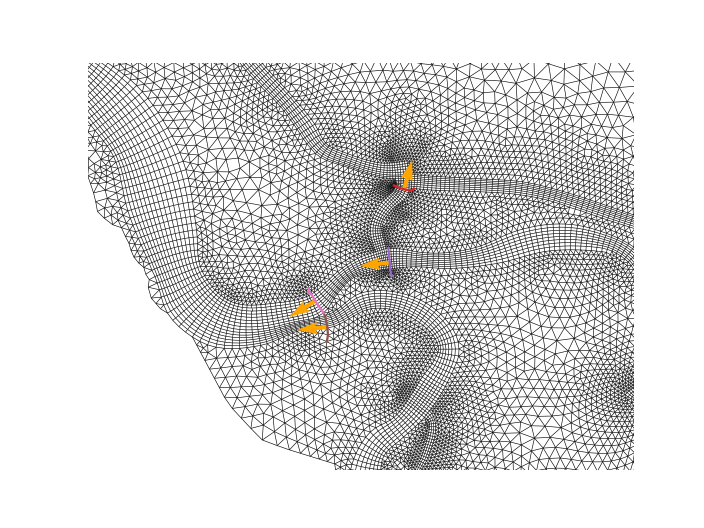

In [28]:
# Check on the sign of the cross sections
# In the plot below, all arrows should be pointing
# downstream. So far this is true for all but PCH.
# Note that the flipping above does *not* flip the
# geometry
plt.figure()
model.grid.plot_edges(lw=0.4,color='k')
plt.axis('off')
plt.axis('tight')
plt.axis('equal')

XY=[]
UV=[]

for xs in his_ds.cross_section.values:
    geom=his_ds.cross_section_geom.sel(cross_section=xs).item()
    plot_wkb.plot_wkb(geom)
    # Which way is the normal pointing?
    pA=np.array(geom.interpolate(0.5,normalized=1))
    pB=np.array(geom.interpolate(0.6,normalized=1))
    
    tang=pB-pA
    right=utils.to_unit(np.r_[tang[1],-tang[0]])
    XY.append(pA)
    UV.append(50*right)
    
XY=np.array(XY)
UV=np.array(UV)
plt.quiver(XY[:,0],XY[:,1],UV[:,0],UV[:,1],color='orange',zorder=2)

In [51]:
# Based on NCK waterlevel predictions
spring_high=np.datetime64('2017-07-23 05:30')
spring_low =np.datetime64('2017-07-23 16:15')
neap_high  =np.datetime64('2017-07-28 23:00')
neap_low   =np.datetime64('2017-07-29 07:30')

for xs in ['mouth_xs','n_complex_xs','n_pond_xs','n_ditch_xs','n_pond_xs',
           'pesca_mid_xs','butano_lower_xs']:
    print(f"{xs}")
    # Find the exact highs, based on tidal volume through mouth
    Qnet=his_ds['cross_section_cumulative_discharge'].sel(cross_section=xs)
    Qnet_lp=filters.lowpass(Qnet,utils.to_dnum(his_ds.time.values),cutoff=3.5)
    Qnet_hp=Qnet-Qnet_lp # sign is opposite of storage. high tide is a local minimum

    spring_high_da=local_max(-Qnet_hp,spring_high)
    spring_low_da =local_max(Qnet_hp,spring_low)
    neap_high_da  =local_max(-Qnet_hp,neap_high)
    neap_low_da   =local_max(Qnet_hp,neap_low)

    # using the fact that high volumes were flipped above,
    spring_dV=spring_high_da.values+spring_low_da.values
    neap_dV=neap_high_da.values+neap_low_da.values
    print(f"  Spring tide tidal prism: {spring_dV:8.0f} m^3")
    print(f"    Neap tide tidal prism: {neap_dV:8.0f} m^3")

mouth_xs
  Spring tide tidal prism:   293661 m^3
    Neap tide tidal prism:    95625 m^3
n_complex_xs
  Spring tide tidal prism:    67936 m^3
    Neap tide tidal prism:    15023 m^3
n_pond_xs
  Spring tide tidal prism:    30382 m^3
    Neap tide tidal prism:     6965 m^3
n_ditch_xs
  Spring tide tidal prism:    21336 m^3
    Neap tide tidal prism:     3834 m^3
n_pond_xs
  Spring tide tidal prism:    30382 m^3
    Neap tide tidal prism:     6965 m^3
pesca_mid_xs
  Spring tide tidal prism:    44215 m^3
    Neap tide tidal prism:    20718 m^3
butano_lower_xs
  Spring tide tidal prism:   110711 m^3
    Neap tide tidal prism:    31831 m^3


<IPython.core.display.Javascript object>


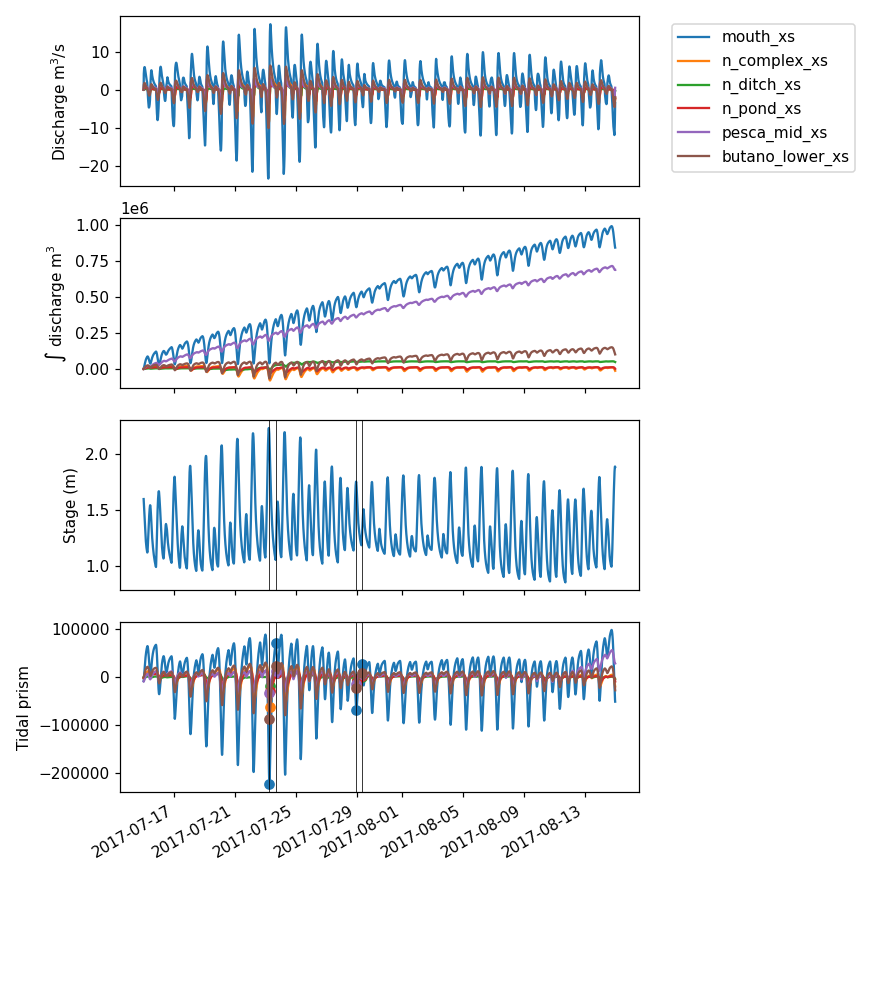

mouth_xs
  Spring tide tidal prism:   293661 m^3   238.1 ac-ft
    Neap tide tidal prism:    95625 m^3    77.5 ac-ft
n_complex_xs
  Spring tide tidal prism:    77229 m^3    62.6 ac-ft
    Neap tide tidal prism:    16701 m^3    13.5 ac-ft
n_ditch_xs
  Spring tide tidal prism:    25858 m^3    21.0 ac-ft
    Neap tide tidal prism:     3935 m^3     3.2 ac-ft
n_pond_xs
  Spring tide tidal prism:    37419 m^3    30.3 ac-ft
    Neap tide tidal prism:     9951 m^3     8.1 ac-ft
pesca_mid_xs
  Spring tide tidal prism:    44215 m^3    35.8 ac-ft
    Neap tide tidal prism:    20718 m^3    16.8 ac-ft
butano_lower_xs
  Spring tide tidal prism:   110711 m^3    89.8 ac-ft
    Neap tide tidal prism:    31831 m^3    25.8 ac-ft


In [60]:
fig,axs=plt.subplots(4,1,sharex=True,figsize=(8,9))

for section in ['mouth_xs','n_complex_xs','n_ditch_xs','n_pond_xs',
                'pesca_mid_xs','butano_lower_xs']:
    if 1: # plot time series
        axs[0].plot(his_ds.time,his_ds['cross_section_discharge'].sel(cross_section=section),label=section)
        axs[1].plot(his_ds.time,his_ds['cross_section_cumulative_discharge'].sel(cross_section=section),label=section)

        Qnet=his_ds['cross_section_cumulative_discharge'].sel(cross_section=section)
        Qnet_lp=filters.lowpass(Qnet,utils.to_dnum(his_ds.time.values),cutoff=3.5)
        Qnet_hp=Qnet-Qnet_lp
        ls=axs[3].plot(his_ds.time, Qnet_hp,label=section)
    
    if 1: # calculate max prism
        spring_high_da=-local_max(-Qnet_hp,spring_high)
        spring_low_da =local_max(Qnet_hp,spring_low)
        neap_high_da  =-local_max(-Qnet_hp,neap_high)
        neap_low_da   =local_max(Qnet_hp,neap_low)

        spring_dV=spring_low_da.values - spring_high_da.values
        neap_dV=neap_low_da.values - neap_high_da.values
        print(section)
        m3_to_acft=0.000810714
        print(f"  Spring tide tidal prism: {spring_dV:8.0f} m^3  {spring_dV*m3_to_acft:6.1f} ac-ft")
        print(f"    Neap tide tidal prism: {  neap_dV:8.0f} m^3  {neap_dV*m3_to_acft:6.1f} ac-ft")
        das=[spring_high_da,spring_low_da,neap_high_da,neap_low_da]
        t=[da.time.values for da in das]
        z=[da.values for da in das]
        axs[3].plot(t,z,marker='o',color=ls[0].get_color(),lw=0.0,label='__nolabel__')    
    
axs[0].set_ylabel('Discharge m$^3$/s')
axs[1].set_ylabel(r'$\int$ discharge m$^3$')
axs[2].plot(his_ds.time, his_ds['waterlevel'].sel(stations='nck'))
axs[3].set_ylabel('Tidal prism')

axs[2].set_ylabel('Stage (m)')


for da in [spring_high_da, spring_low_da, neap_high_da, neap_low_da]:
    axs[2].axvline(da.time.values,color='k',lw=0.5)
    axs[3].axvline(da.time.values,color='k',lw=0.5)

axs[0].legend(loc='upper left',bbox_to_anchor=[1.05,1.0])
fig.tight_layout()
fig.autofmt_xdate()

In [67]:
map_ds=xr.open_dataset(model.map_outputs()[0])
map_ds

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 116116, mesh2d_nFaces: 71832, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 44282, time: 63)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 ...
    mesh2d_node_y                (mesh2d_nNodes) float64 ...
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 ...
    mesh2d_face_y                (mesh2d_nFaces) float64 ...
  * time                         (time) datetime64[ns] 2017-07-15 ... 2017-08-15
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 ...
    mesh2d                       int32 ...
    mesh2d_node_z                (mesh2d_nNodes) float64 ...
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 ...
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) float64 ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 ...
    mesh2d_flowelem_bl           (mesh2d_nFaces) float64 ...
    timestep                     (time) float64 ...
    mesh2d_Numlimdt              (time, mesh2d_nFaces) float64 ...
    mesh2d_waterdepth            (time, mesh2d_nFaces) float64 ...
    mesh2d_s1                    (time, mesh2d_nFaces) float64 ...
    mesh2d_u1                    (time, mesh2d_nEdges) float64 ...
    mesh2d_u0                    (time, mesh2d_nEdges) float64 ...
    mesh2d_ucx                   (time, mesh2d_nFaces) float64 ...
    mesh2d_ucy                   (time, mesh2d_nFaces) float64 ...
    mesh2d_ucmag                 (time, mesh2d_nFaces) float64 ...
    mesh2d_q1                    (time, mesh2d_nEdges) float64 ...
    mesh2d_viu                   (time, mesh2d_nEdges) float64 ...
    mesh2d_diu                   (time, mesh2d_nEdges) float64 ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 ...
    mesh2d_czu                   (time, mesh2d_nEdges) float64 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         D-Flow FM 1.2.110.68456M. Model:
    history:        Created on 2021-10-22T13:27:01-0700, D-Flow FM
    date_created:   2021-10-22T13:27:01-0700
    date_modified:  2021-10-22T13:27:01-0700
    Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10

<IPython.core.display.Javascript object>


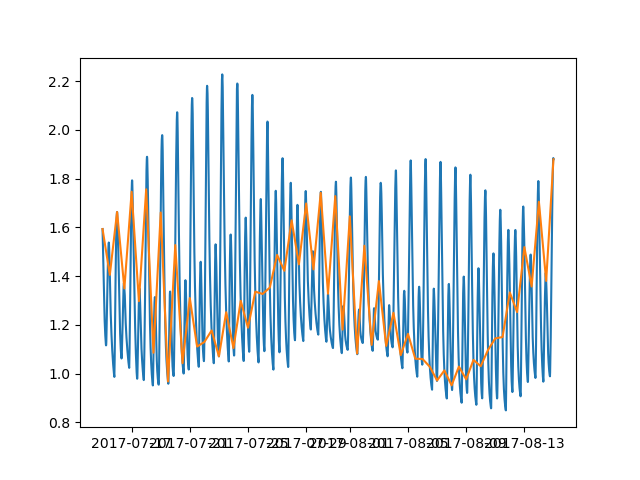

In [72]:
# Map output isn't going to hit the high points too well.
# see if we get lucky, though.
# Not lucky.

plt.figure()
plt.plot(his_ds.time,his_ds.waterlevel.sel(stations='nck'))
plt.plot(map_ds.time, his_ds.waterlevel.sel(stations='nck').sel(time=map_ds.time.values, method='nearest'))

In [73]:
model.map_outputs()[0]

'/media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p08/DFM_OUTPUT_flowfm/flowfm_map.nc'

In [81]:
map_ds

<xarray.Dataset>
Dimensions:                      (Two: 2, mesh2d_nEdges: 116116, mesh2d_nFaces: 71832, mesh2d_nMax_face_nodes: 4, mesh2d_nNodes: 44282, time: 63)
Coordinates:
    mesh2d_node_x                (mesh2d_nNodes) float64 5.541e+05 ... 5.523e+05
    mesh2d_node_y                (mesh2d_nNodes) float64 4.123e+06 ... 4.125e+06
    mesh2d_edge_x                (mesh2d_nEdges) float64 ...
    mesh2d_edge_y                (mesh2d_nEdges) float64 ...
    mesh2d_face_x                (mesh2d_nFaces) float64 5.541e+05 ... 5.524e+05
    mesh2d_face_y                (mesh2d_nFaces) float64 4.123e+06 ... 4.125e+06
  * time                         (time) datetime64[ns] 2017-07-15 ... 2017-08-15
Dimensions without coordinates: Two, mesh2d_nEdges, mesh2d_nFaces, mesh2d_nMax_face_nodes, mesh2d_nNodes
Data variables:
    projected_coordinate_system  int32 -2147483647
    mesh2d                       int32 -2147483647
    mesh2d_node_z                (mesh2d_nNodes) float64 0.0 0.0 ... 3.984 3.651
    mesh2d_edge_nodes            (mesh2d_nEdges, Two) int32 ...
    mesh2d_face_nodes            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_faces            (mesh2d_nEdges, Two) float64 ...
    mesh2d_face_x_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_face_y_bnd            (mesh2d_nFaces, mesh2d_nMax_face_nodes) float64 ...
    mesh2d_edge_type             (mesh2d_nEdges) float64 ...
    mesh2d_flowelem_ba           (mesh2d_nFaces) float64 11.37 12.27 ... 177.2
    mesh2d_flowelem_bl           (mesh2d_nFaces) float64 0.0 0.0 ... 1.876 2.349
    timestep                     (time) float64 1.0 2.439 2.439 ... 2.609 2.609
    mesh2d_Numlimdt              (time, mesh2d_nFaces) float64 ...
    mesh2d_waterdepth            (time, mesh2d_nFaces) float64 ...
    mesh2d_s1                    (time, mesh2d_nFaces) float64 ...
    mesh2d_u1                    (time, mesh2d_nEdges) float64 ...
    mesh2d_u0                    (time, mesh2d_nEdges) float64 ...
    mesh2d_ucx                   (time, mesh2d_nFaces) float64 ...
    mesh2d_ucy                   (time, mesh2d_nFaces) float64 ...
    mesh2d_ucmag                 (time, mesh2d_nFaces) float64 ...
    mesh2d_q1                    (time, mesh2d_nEdges) float64 ...
    mesh2d_viu                   (time, mesh2d_nEdges) float64 ...
    mesh2d_diu                   (time, mesh2d_nEdges) float64 ...
    mesh2d_taus                  (time, mesh2d_nFaces) float64 ...
    mesh2d_czs                   (time, mesh2d_nFaces) float64 ...
    mesh2d_czu                   (time, mesh2d_nEdges) float64 ...
Attributes:
    institution:    Deltares
    references:     http://www.deltares.nl
    source:         D-Flow FM 1.2.110.68456M. Model:
    history:        Created on 2021-10-22T13:27:01-0700, D-Flow FM
    date_created:   2021-10-22T13:27:01-0700
    date_modified:  2021-10-22T13:27:01-0700
    Conventions:    CF-1.8 UGRID-1.0 Deltares-0.10

In [77]:
# 1 month at 12h map output is 624M
# To get some inundation maps I really only need the first half of that


In [79]:
ls -lh /media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p08/DFM_OUTPUT_flowfm/flowfm_map.nc

-rwxr-xr-x 1 rusty root 624M Oct 22 20:12 /media/cws/hydro/Pescadero/Model_Runs/Production/run_tide_test-p08/DFM_OUTPUT_flowfm/flowfm_map.nc*
